## Exercício 

Desenvolva uma rede neural MLP para classificar o dataset Kuzushiji-MNIST. O objetivo é conseguir a melhor acurácia no conjunto de teste.

Sugestões:

- Testar diferentes configurações, como número de camadas escondidas e neurônios por camadas;
- Testar como funciona com ou sem dropout;
- Testar diferentes otimizadores (não apenas SGD) e diferentes valores de taxa de aprendizado;
- Testar possiveis transformações no dataset;
- Testar diferente números de épocas.


### Importando as bibliotecas

In [1]:
import torch
import helper
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix
from torch.autograd import Variable
import matplotlib.pyplot as plt

### Baixando o dataset e definindo a normalização

In [2]:
# Define as transformações para normalizar os dados
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Baixa e carrega o conjunto de treinamento
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# baixa e carrega o conjunto de testes
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Using downloaded and verified file: /home/igornieto/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting /home/igornieto/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /home/igornieto/.pytorch/MNIST_data/MNIST/raw


102.8%


Extracting /home/igornieto/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /home/igornieto/.pytorch/MNIST_data/MNIST/raw




100.0%


Extracting /home/igornieto/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/igornieto/.pytorch/MNIST_data/MNIST/raw



112.7%

Extracting /home/igornieto/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/igornieto/.pytorch/MNIST_data/MNIST/raw



### Visualizando uma imagem do dataset

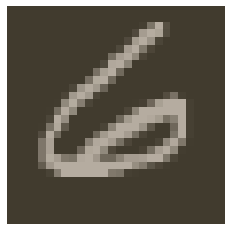

In [3]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);
helper.plt.show()

### Criando a classe da estrutura da rede SEM regularização

In [4]:
class Classifier(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers):
        '''
        Classe responsável por criar a estrutura da rede sendo:
        input_size: tamanho da entrada dos dados
        output_size: tamanho da saida, ou seja,  o número de classes
        hidden_layers: camadas escondidas
        '''
        super().__init__()
        # Entrada para a primeira camada oculta
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Adicionando as outras camadas ocultas
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
    def forward(self, x):
        '''
        Passando as camadas na função de ativação ReLU
        e a última na função de ativação log_softmax, sem regularização.
        '''
        x = x.view(x.shape[0],-1) # Achatando a imagem em uma única dimensão
        for each in self.hidden_layers:
            x = F.relu(each(x))
            
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)

### Criando a classe da estrutura da rede COM regularização

In [5]:
class Classifier_reg(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        '''Classe responsável por criar a estrutura da rede sendo:
        input_size: tamanho da entrada dos dados
        output_size: tamanho da saida, ou seja, o número de classes
        hidden_layers: camadas escondidas
        drop_p: porcentagem de neuronios dropados/retirados em cada camada
           
        '''
        super().__init__()
        # Entrada para a primeira camada oculta
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
         # Adicionando as outras camadas ocultas
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        '''
        Passando as camadas na função de ativação ReLU
        e a última na função de ativação log_softmax, mas com regularização.
        '''
        x = x.view(x.shape[0],-1)
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)

### Função para treinamento da rede

In [6]:
def treinamento(model, criterion, optimizer, epochs):
    '''
    Função responsável por executar todo o treinamento da rede com
    validação
    
    '''
    
    train_losses, test_losses = [], []
    for e in range(epochs):
        running_loss = 0
        for image, label in trainloader: # treinamento
            optimizer.zero_grad() # Zera o gradiente
            log_ps = model(image)
            loss = criterion(log_ps, label) # calcula o custo
            loss.backward() # propaga o erro para tras
            optimizer.step() # atualiza os pesos

            running_loss+=loss.item() # soma os custos
        else: # começando a parte de validação
            test_loss = 0
            accuracy = 0
            with torch.no_grad(): # Desligando o gradiente
                model.eval() #Iniciando o modelo no modo teste
                for image, label in testloader:         

                    log_ps = model.forward(image) # fazendo o passo forward
                    prob = torch.exp(log_ps) # Pegando a saida da softmax e fazendo a exponencial(gera um tensor com 10 posições sendo que cada posição
                                             # é uma classe e em cada posição tem a probabilidade da amostra ser dessa classe )

                    test_loss+= criterion(log_ps, label) # Soma o resultado da função de custo


                    k_prob, k_class = prob.topk(1, dim=1) #pegando, na saida da rede, a classe com maior probabilidade
                    equals = k_class == label.view(*k_class.shape) # verificando se a classe predita é igual a verdadeira( gera um tensor com 
                                                                   # vários 'True' e 'false')

                    accuracy+= torch.mean(equals.type(torch.FloatTensor)) # transforma os valores booleanos em float e calcula a média

            model.train() # Volta o modelo para o modo de treino
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

### Treinando a rede

In [7]:
model = Classifier(784, 10, [512, 256, 128]) #Modelo sem regularização

criterion = nn.NLLLoss()

optimizer_Adam = optim.Adam(model.parameters(), lr=0.003)
optimizer_ASGD = optim.ASGD(model.parameters(), lr=0.003)
optimizer_Adamax = optim.Adamax(model.parameters(), lr=0.003)

teste = treinamento(model, criterion, optimizer_Adam, epochs = 10)

Epoch: 1/10..  Training Loss: 0.336..  Test Loss: 0.196..  Test Accuracy: 0.942
Epoch: 2/10..  Training Loss: 0.172..  Test Loss: 0.137..  Test Accuracy: 0.959
Epoch: 3/10..  Training Loss: 0.139..  Test Loss: 0.166..  Test Accuracy: 0.954
Epoch: 4/10..  Training Loss: 0.119..  Test Loss: 0.158..  Test Accuracy: 0.957
Epoch: 5/10..  Training Loss: 0.106..  Test Loss: 0.126..  Test Accuracy: 0.962
Epoch: 6/10..  Training Loss: 0.100..  Test Loss: 0.116..  Test Accuracy: 0.966
Epoch: 7/10..  Training Loss: 0.093..  Test Loss: 0.103..  Test Accuracy: 0.971
Epoch: 8/10..  Training Loss: 0.088..  Test Loss: 0.109..  Test Accuracy: 0.969
Epoch: 9/10..  Training Loss: 0.081..  Test Loss: 0.113..  Test Accuracy: 0.968
Epoch: 10/10..  Training Loss: 0.082..  Test Loss: 0.099..  Test Accuracy: 0.971


### Verificando a rede

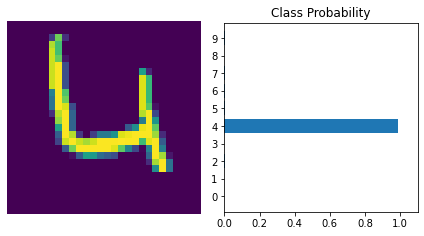

In [8]:
model.eval()
dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convertendo imagens 2D em tensores 1D
img = img.view(1, 784)
# Computando o log das probabilidades para cada imagem (com log_softmax)
with torch.no_grad():
    output = model.forward(img)

# computa as probabilidades fazendo o exponencial do log das probabilidades 
ps = torch.exp(output)
# plotando as probabilidades
helper.view_classify(img.view(1, 28, 28), ps, version='MNIST')
helper.plt.show()

In [9]:
y_test = []
y_pred = []
with torch.no_grad():
        # Desligando o gradiente
        model.eval() #Iniciando o modelo no modo teste
        for image, label in testloader:         

            log_ps = model.forward(image) # fazendo o passo forward
            prob = torch.exp(log_ps) # Pegando a saida da softmax e fazendo a exponencial(gera um tensor com 10 posições sendo que cada posição
                                     # é uma classe e em cada posição tem a probabilidade da amostra ser dessa classe )

            k_prob, k_class = prob.topk(1, dim=1) #pegando, na saida da rede, a classe com maior probabilidade
            y_test.append(label.numpy().tolist())
            y_pred.append(k_class.numpy().tolist())
             
            

teste = []
for l in y_test:
    for i in l:
        teste.append(i)

pred = []
for l in y_pred:
    for i in l:
        pred.append(i)        

### Matriz confusão

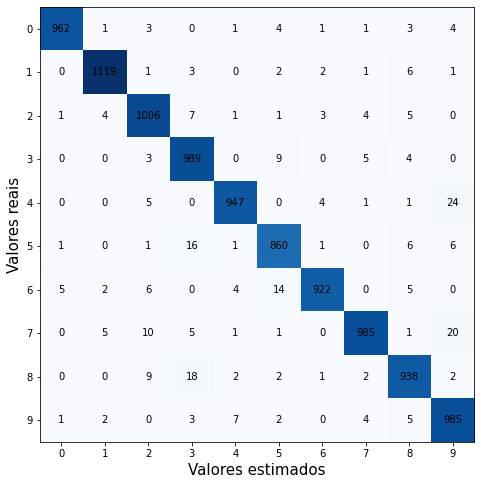

In [10]:
model.eval()
cm = confusion_matrix(teste, pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm, cmap=plt.cm.Blues)
ax.grid(False)
ax.set_xlabel('Valores estimados', fontsize=15, color='black')
ax.set_ylabel('Valores reais', fontsize=15, color='black')
ax.xaxis.set(ticks=range(10))
ax.yaxis.set(ticks=range(10))
ax.set_ylim(9.5, -0.5)
for i in range(10):
    for j in range(10):
        ax.text(j, i, cm[i, j], ha='center', va='center')
plt.show()

In [11]:
model_reg = Classifier_reg(784, 10, [512, 256, 128]) # Modelo com regularização
criterion = nn.NLLLoss()

optimizer_Adam = optim.Adam(model_reg.parameters(), lr=0.003)
optimizer_ASGD = optim.ASGD(model_reg.parameters(), lr=0.003)
optimizer_Adamax = optim.Adamax(model_reg.parameters(), lr=0.003)

teste = treinamento(model_reg, criterion, optimizer_Adam, epochs = 10)

Epoch: 1/10..  Training Loss: 0.875..  Test Loss: 0.359..  Test Accuracy: 0.899
Epoch: 2/10..  Training Loss: 0.642..  Test Loss: 0.328..  Test Accuracy: 0.908
Epoch: 3/10..  Training Loss: 0.630..  Test Loss: 0.346..  Test Accuracy: 0.898
Epoch: 4/10..  Training Loss: 0.598..  Test Loss: 0.330..  Test Accuracy: 0.910
Epoch: 5/10..  Training Loss: 0.565..  Test Loss: 0.288..  Test Accuracy: 0.925
Epoch: 6/10..  Training Loss: 0.558..  Test Loss: 0.285..  Test Accuracy: 0.928
Epoch: 7/10..  Training Loss: 0.558..  Test Loss: 0.320..  Test Accuracy: 0.918
Epoch: 8/10..  Training Loss: 0.576..  Test Loss: 0.339..  Test Accuracy: 0.918
Epoch: 9/10..  Training Loss: 0.588..  Test Loss: 0.316..  Test Accuracy: 0.918
Epoch: 10/10..  Training Loss: 0.576..  Test Loss: 0.296..  Test Accuracy: 0.924


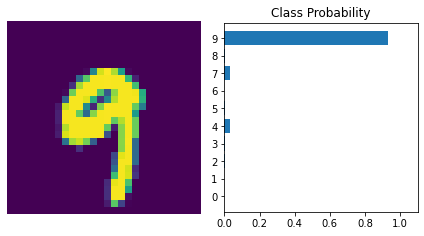

In [12]:
## INFERÊNCIA

# Testando nossa rede

model_reg.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convertendo imagens 2D em tensores 1D
img = img.view(1, 784)

# Computando o log das probabilidades para cada imagem (com log_softmax)
with torch.no_grad():
    output = model_reg.forward(img)

# computa as probabilidades fazendo o exponencial do log das probabilidades 
ps = torch.exp(output)

# plotando as probabilidades
helper.view_classify(img.view(1, 28, 28), ps, version='MNIST')
helper.plt.show()